In [1]:
from datetime import datetime, timedelta, time
import pandas as pd
import numpy as np
import datajoint as dj
from pipeline import pipeline_tools, lab, experiment, behavioranal
dj.conn()
import matplotlib.pyplot as plt
import decimal
%matplotlib inline

Connecting rozmar@mesoscale-activity.datajoint.io:3306


# Weight change and water consumption
All mice returned to baseline weight despite they drink little water..

Text(0.5, 1.0, 'Water consumption over training')

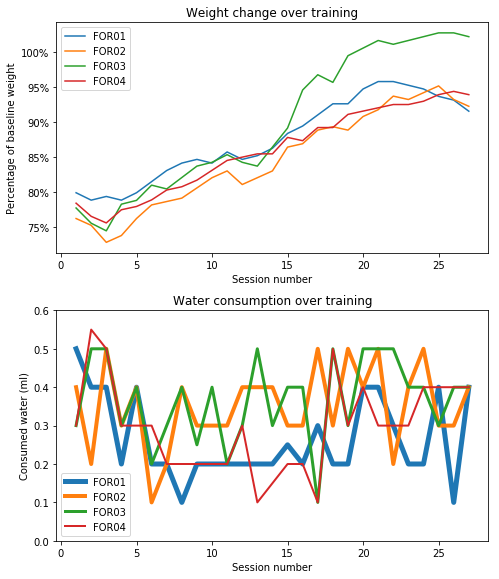

In [2]:
df_subject_wr=pd.DataFrame(lab.WaterRestriction() * experiment.Session() * experiment.SessionDetails)
subject_names = df_subject_wr['water_restriction_number'].unique()
subject_names.sort()
fig=plt.figure()
ax_weight=fig.add_axes([0,0,1,.8])
for i,subject in enumerate(subject_names):
    idx = df_subject_wr['water_restriction_number'] == subject
    weights = df_subject_wr['session_weight'][idx] /df_subject_wr['wr_start_weight'][idx]
    ax_weight.plot(range(1,len(weights)+1),weights.values)
vals = ax_weight.get_yticks()
ax_weight.set_yticklabels(['{:,.0%}'.format(x) for x in vals])
ax_weight.set_ylabel('Percentage of baseline weight')
ax_weight.set_xlabel('Session number')
ax_weight.legend(subject_names)
ax_weight.set_title('Weight change over training')

ax_water = fig.add_axes([0,-1,1,.8])
for i,subject in enumerate(subject_names):
    idx = df_subject_wr['water_restriction_number'] == subject
    water = df_subject_wr['session_water_earned'][idx]
    ax_water.plot(range(1,len(water)+1),water.values,linewidth=len(subject_names)+1-i)
ax_water.set_ylabel('Consumed water (ml)')
ax_water.set_xlabel('Session number')
ax_water.set_ylim(0, .6)
ax_water.legend(subject_names)
ax_water.set_title('Water consumption over training')

# reaction times for the last session:
The first two mice (Bari-Cohen training) are trying to guess the GO cue

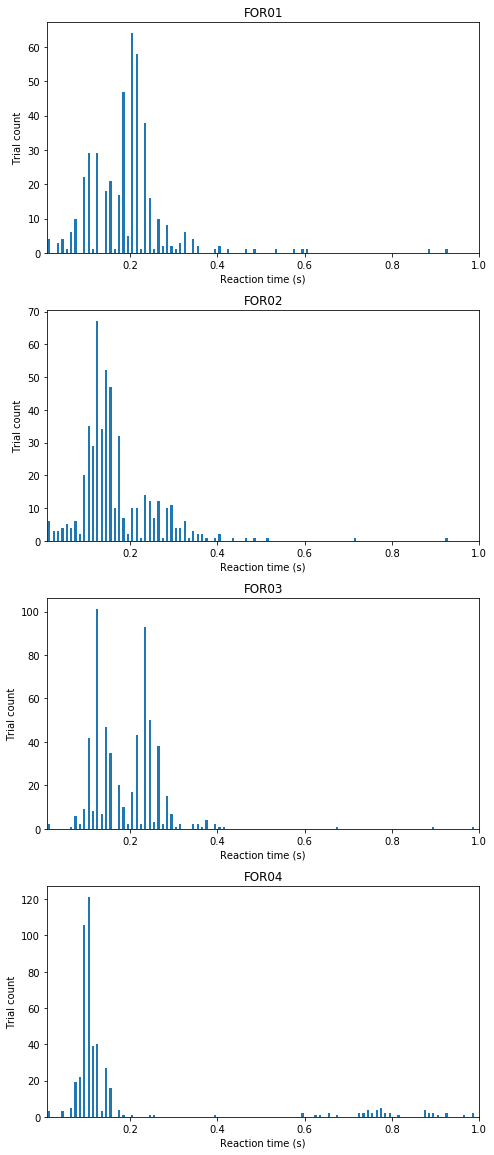

In [3]:
session = experiment.Session().fetch('session').max()
key = {'session':session}
df_reactiontime = pd.DataFrame((behavioranal.SessionReactionTimeHistogram() & key)*(lab.WaterRestriction &key))
fig=plt.figure()
ax_RT = list()
for i,subject in enumerate(subject_names):
    ax_RT.append(fig.add_axes([0,-i,1,.8]))
    idx = df_reactiontime['water_restriction_number'] == subject
    bins = df_reactiontime['reaction_time_bins'][idx].values[0][1:]
    edges = [np.min(bins),np.max(bins)]
    bins = bins - (bins[1] -bins[0])/2
    vals = df_reactiontime['reaction_time_values_all_trials'][idx].values.tolist()[0]
    ax_RT[-1].bar(bins,vals, (bins[1] -bins[0])/2)
    ax_RT[-1].set_xlim(edges)
    ax_RT[-1].set_title(subject)
    ax_RT[-1].set_xlabel('Reaction time (s)')
    ax_RT[-1].set_ylabel('Trial count')

# Number of licks on miss trials after the first lick in each session:
(if the retraction is fast enough, it should be 0) \n
Sessions 1-7 : softcode and slow motor movement \n
Sessions 7-11 : softcode and fast motor movement \n
Sessions 12-19: same as above but two bpods controlled from the same PC \n
Sessions 19- : zaber motor is directly triggered

Text(0.5, 1.0, 'Lick count on miss trials')

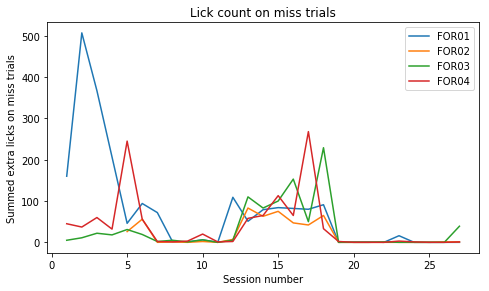

In [4]:
#%% licks on miss trials
df_misslicknums = pd.DataFrame()
fig=plt.figure()
ax_misslick = fig.add_axes([0,0,1,.8])
for wr_name in subject_names:
    #%
    subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
    key = {'subject_id':subject_id}   
    df_lickrhythm = pd.DataFrame((behavioranal.SessionLickRhythmHistogram() & key)*(lab.WaterRestriction &key))
    #%
    
    sessionnum = list()
    licknum = list()
    for i,session in enumerate(df_lickrhythm['session']):
        idx = df_lickrhythm['session'] == session
        bins = df_lickrhythm['lick_rhythm_bins'][idx].values[0][1:]
        edges = [np.min(bins),np.max(bins)]
        bins = bins - (bins[1] -bins[0])/2 
        vals = df_lickrhythm['lick_rhythm_values_miss_trials'][idx].values.tolist()[0]
        sessionnum.append(session)
        licknum.append(vals[bins>.015].sum())       
    ax_misslick.plot(sessionnum,licknum)
ax_misslick.set_ylabel('Summed extra licks on miss trials')
ax_misslick.set_xlabel('Session number')
ax_misslick.legend(subject_names)
ax_misslick.set_title('Lick count on miss trials')

# One nice session:

In [5]:
wr_name = 'FOR02'
subject_id = (lab.WaterRestriction() & 'water_restriction_number = "'+wr_name+'"').fetch('subject_id')[0]
session = 23
df_behaviortrial = pd.DataFrame(((experiment.BehaviorTrial() & 'subject_id = '+str(subject_id) & 'session = '+str(session)) * experiment.SessionTrial() * experiment.SessionBlock()).fetch())
df_session=pd.DataFrame(experiment.Session() & 'session = '+str(session) & 'subject_id = '+str(subject_id))
df_session

,subject_id,session,session_date,session_time,username,rig
0,453475,23,2019-07-17,16:39:04,rozsam,Training-Tower-2


In [6]:
df_behaviortrial['trial_choice_plot'] = np.nan
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='left']=0
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='right']=1
df_behaviortrial['reward_ratio']=df_behaviortrial['p_reward_right']/(df_behaviortrial['p_reward_right']+df_behaviortrial['p_reward_left'])

/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
df_behaviortrial['trial_choice_plot'] = np.nan
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='left']=0
df_behaviortrial['trial_choice_plot'][df_behaviortrial['trial_choice']=='right']=1
df_behaviortrial['reward_ratio']=df_behaviortrial['p_reward_right']/(df_behaviortrial['p_reward_right']+df_behaviortrial['p_reward_left'])

binsize = 5
bias = list()
for idx in range(len(df_behaviortrial)):
    if idx < round(binsize/2) or idx > len(df_behaviortrial)-round(binsize/2):
        bias.append(np.nan)
    else:
        bias_now = np.mean(df_behaviortrial['trial_choice_plot'][idx-round(binsize/2):idx+round(binsize/2)])
        bias.append(bias_now)
        
rewarded = (df_behaviortrial['outcome']=='hit')
unrewarded = (df_behaviortrial['outcome']=='miss')

choicesback = 10
rewardratio_L = list()
rewardratio_R = list()
#rewardratio_combined = list()
for idx in range(len(df_behaviortrial)):
    if idx < choicesback:
        rewardratio_L.append(np.nan)
        rewardratio_R.append(np.nan)
    else:
        choices_L=sum((df_behaviortrial['trial_choice']=='left')[idx-choicesback:idx])
        rewards_L=sum(((df_behaviortrial['trial_choice']=='left')&(df_behaviortrial['outcome']=='hit'))[idx-choicesback:idx])
        choices_R=sum((df_behaviortrial['trial_choice']=='right')[idx-choicesback:idx])
        rewards_R=sum(((df_behaviortrial['trial_choice']=='right')&(df_behaviortrial['outcome']=='hit'))[idx-choicesback:idx])
        if choices_L == 0:
            rewardratio_L_now= np.nan
        else:
            rewardratio_L_now = rewards_L/choices_L
        rewardratio_L.append(rewardratio_L_now)
        
        if choices_R == 0:
            rewardratio_R_now= np.nan
        else:
            rewardratio_R_now = rewards_R/choices_R
        
        rewardratio_R.append(rewardratio_R_now)

rewardratio_R = np.array(rewardratio_R)
rewardratio_L = np.array(rewardratio_L)




/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


/home/rozmar/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in true_divide
  import sys


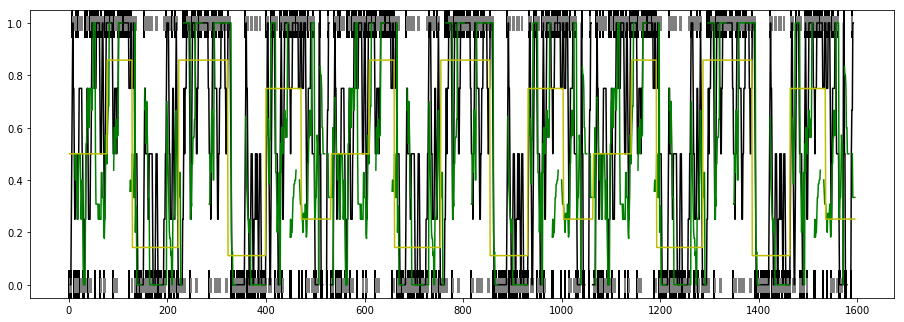

In [8]:

fig=plt.figure()
ax1=fig.add_axes([0,0,2,1])
ax1.plot(df_behaviortrial['trial'][rewarded],df_behaviortrial['trial_choice_plot'][rewarded],'k|',color='black',markersize=30,markeredgewidth=2)
ax1.plot(df_behaviortrial['trial'][unrewarded],df_behaviortrial['trial_choice_plot'][unrewarded],'|',color='gray',markersize=15,markeredgewidth=2)
ax1.plot(df_behaviortrial['trial'],bias,'k-')
ax1.plot(df_behaviortrial['trial'],rewardratio_R / (rewardratio_R+rewardratio_L),'g-')
ax1.plot(df_behaviortrial['trial'],df_behaviortrial['reward_ratio'],'y-')
#ax1.plot(df_behaviortrial['trial'],rewardratio_L,'b-')
#ax1.plot(df_behaviortrial['trial'],rewardratio_R,'r-')
#ax1.set_xlim(500, 600)